In [2]:
# face verification with the VGGFace2 model
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
# from keras_vggface.vggface import VGGFace
# from keras_vggface.utils import preprocess_input
import pandas as pd

# # extract a single face from a given photograph
# def extract_face(filename, required_size=(224, 224)):
#     # load image from file
# #     pixels = pyplot.imread(filename)
# #     # create the detector, using default weights
# #     detector = MTCNN()
# #     # detect faces in the image
# #     results = detector.detect_faces(pixels)
# #     # extract the bounding box from the first face
# #     x1, y1, width, height = results[0]['box']
# #     x2, y2 = x1 + width, y1 + height
# #     # extract the face
# #     face = pixels[y1:y2, x1:x2]
#     # resize pixels to the model size
#     image = Image.open(filename)
#     image = image.resize(required_size)
#     face_array = asarray(image)
#     return face_array

# def prepare_file(filenames):
#     # extract faces
#     faces = [extract_face(f) for f in filenames]
#     # convert into an array of samples
#     samples = asarray(faces, 'float32')
#     # prepare the face for the model, e.g. center pixels
#     return preprocess_input(samples, version=2)

# model = None
# # extract faces and calculate face embeddings for a list of photo files
# def get_embeddings(filenames):
#     # extract faces
#     faces = [extract_face(f) for f in filenames]
#     # convert into an array of samples
#     samples = asarray(faces, 'float32')
#     # prepare the face for the model, e.g. center pixels
#     samples = preprocess_input(samples, version=2)
#     # create a vggface model
#     global model
#     if not model:
#         model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
#     # perform prediction
#     yhat = model.predict(samples)
#     return yhat

# # determine if a candidate face is a match for a known face
# def is_match(known_embedding, candidate_embedding, thresh=0.5):
#     # calculate distance between embeddings
#     score = cosine(known_embedding, candidate_embedding)
#     if score <= thresh:
#         print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
#         return True, score
#     else:
#         print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
#         return False, score

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

In [4]:
BASE_PATH = pathlib.Path('../data/mfr2')
labels_path = BASE_PATH / 'mfr2_labels.txt'
pairs_path = BASE_PATH / 'pairs.txt'

In [5]:
labels=pd.read_csv(filepath_or_buffer=str(labels_path))
labels=labels.apply(lambda x: x.apply(lambda y: y.strip() if type(y) == type('') else y), axis=0)
people=labels["person"].unique()

def get_indexes(person, mask=True):
    if mask:
        mask_filter = labels["mask"]!="no-mask"
    else:
        mask_filter = labels["mask"]=="no-mask"
    person_filter = labels["person"]==person
    return list(labels[person_filter & mask_filter]["index"])

total_pairs={person:list(zip(get_indexes(person,mask=True), get_indexes(person, mask=False))) for person in people}

In [6]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

person, pairs = list(total_pairs.items())[0]
index1, index2 = pairs[0]
path1 = BASE_PATH / person / f'{person}_{str(index1).rjust(4, "0")}.png'
path2 = BASE_PATH / person / f'{person}_{str(index2).rjust(4, "0")}.png'
# read images
img1 = cv2.imread(str(path1))  
img2 = cv2.imread(str(path2))

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) 
flann = cv2.FlannBasedMatcher(index_params,search_params)
k_matches = flann.knnMatch(descriptors_1,descriptors_2, k=2)

# Apply ratio test
good = []
for m,n in k_matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        a=len(good)
        percent=(a*100)/len(keypoints_2)
        print("{} % similarity".format(percent))
        if percent >= 75.00:
            print('Match Found')
        if percent < 75.00:
            print('Match not Found')

0.7936507936507936 % similarity
Match not Found
1.5873015873015872 % similarity
Match not Found


In [15]:
k_matches[0][1].distance

362.8636169433594

In [20]:
results = []

# positive test
for person, pairs in total_pairs.items():
    for index1, index2 in pairs:
        path1 = BASE_PATH / person / f'{person}_{str(index1).rjust(4, "0")}.png'
        path2 = BASE_PATH / person / f'{person}_{str(index2).rjust(4, "0")}.png'

        # read images
        img1 = cv2.imread(str(path1))  
        img2 = cv2.imread(str(path2))

        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        #sift
        sift = cv2.xfeatures2d.SIFT_create()

        keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
        keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50) 
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        k_matches = flann.knnMatch(descriptors_1,descriptors_2, k=2)

        # Apply ratio test
        good = 0
        for m,n in k_matches:
            if m.distance < 0.75*n.distance:
                good+=1
        matched = good > 50
        results.append([(person, index1, index2), matched, good])

In [7]:
# results = []

# # positive test
# for pair in pairs:
#     (person1,index1),(person2,index2) = pair
#     path1 = BASE_PATH / person1 / f'{person1}_{str(index1).rjust(4, "0")}.png'
#     path2 = BASE_PATH / person2 / f'{person2}_{str(index2).rjust(4, "0")}.png'
    
# #     try:
#     features1,features2=get_embeddings([path1, path2])
#     matched, distance = is_match(features1, features2)
# #     except Exception as e:
# #         print(e)
# #         continue
    
#     results.append([pair, matched, distance])

In [8]:
TP=len([x for x in results if x[1]]) / len(results)
FN=1-TP

In [9]:
TP

0.5934065934065934

In [10]:
FN

0.4065934065934066

In [11]:
len(list(BASE_PATH.iterdir()))

55

In [21]:
import random
results_neg = []
count = 0

for person1 in BASE_PATH.iterdir():
    random_people = list(BASE_PATH.iterdir())
    random.shuffle(random_people)
    i=0
    for person2 in random_people:
        if not person1.is_dir() or not person2.is_dir() or person1.name == person2.name or not person1.name.isalpha() or not person2.name.isalpha():
            continue
        count += 1
        if count >= len(results):
            break
        index1 = index2 = 1
        
        path1 = BASE_PATH / person1.name / f'{person1.name}_{str(index1).rjust(4, "0")}.png'
        path2 = BASE_PATH / person2.name / f'{person2.name}_{str(index2).rjust(4, "0")}.png'

        try:
            # read images
            img1 = cv2.imread(str(path1))  
            img2 = cv2.imread(str(path2))

            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

            #sift
            sift = cv2.xfeatures2d.SIFT_create()

            keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
            keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

            FLANN_INDEX_KDTREE = 0
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks=50) 
            flann = cv2.FlannBasedMatcher(index_params,search_params)
            k_matches = flann.knnMatch(descriptors_1,descriptors_2, k=2)

            # Apply ratio test
            good = 0
            for m,n in k_matches:
                if m.distance < 0.75*n.distance:
                    good+=1
            matched = good > 50
        except Exception as e:
            print(e)
            continue

        results_neg.append([(person1, person2), matched, good])

In [22]:
FP=len([x for x in results_neg if x[1]]) / len(results_neg)
TN=1-FP

In [23]:
len(results)

91

In [24]:
len(results_neg)

90

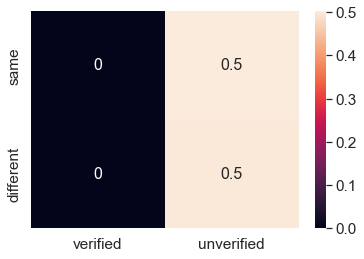

In [25]:
TP=len([x for x in results if x[1]]) / (len(results) + len(results_neg))
FN=len([x for x in results if not x[1]]) / (len(results) + len(results_neg))
FP=len([x for x in results_neg if x[1]]) / (len(results) + len(results_neg))
TN=len([x for x in results_neg if not x[1]]) / (len(results) + len(results_neg))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[TP,FN],
         [FP,TN]]

df_cm = pd.DataFrame(array, ['same', 'different'], ['verified', 'unverified'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [26]:
from sklearn import svm
X = [x[2] for x in results] + [x[2] for x in results_neg]
y = [1 for x in results] + [0 for x in results_neg]
clf = svm.SVC() #kernel="linear")
clf.fit(np.array(X).reshape(-1, 1), y)

SVC()

In [27]:
ps=clf.predict(np.array([x[2] for x in results]).reshape(-1, 1))

In [28]:
len([x for x in ps if x == 1])

59

In [29]:
ns=clf.predict(np.array([x[2] for x in results_neg]).reshape(-1, 1))

In [30]:
np.array([x[2] for x in results + results_neg])

array([ 2,  3,  1, 13,  0,  1,  2,  3,  4,  2,  2,  1,  5, 11,  3,  1,  4,
       12,  3, 10,  2,  1,  2,  4,  4,  5,  5, 18,  1,  5,  5,  4,  2,  5,
        0,  3,  1,  3,  3,  3,  2,  6,  4,  9,  5,  4,  0,  9,  4,  5,  6,
        5,  1,  8,  5,  2, 17,  3,  2, 10,  6,  0,  3,  5,  1,  2,  1,  5,
        2,  2,  4,  4,  4,  4,  1,  0,  4,  2,  5,  3,  5,  0,  3,  3,  5,
       12,  8,  7,  1,  5,  4,  1,  0,  6,  5,  1,  2,  4,  1,  2,  5,  2,
        2,  1,  2,  3,  1,  1,  3,  3,  5,  2,  1,  1,  0,  0,  1,  1,  1,
        4,  1,  0,  3,  0,  2,  3,  2,  2,  1,  0,  1,  0,  2,  2,  3,  2,
        0,  1,  0,  1,  0,  1,  0,  0,  1,  2,  2,  1,  0,  0,  2,  1,  3,
        3,  2,  3,  0,  2,  4,  1,  0,  3,  3,  1,  0,  5,  3,  4,  2,  2,
        0,  0,  7,  2,  1,  4,  0,  4,  4,  2,  2])

In [31]:
len([x for x in ps if x == 0])

32

In [32]:
len(ps)

91

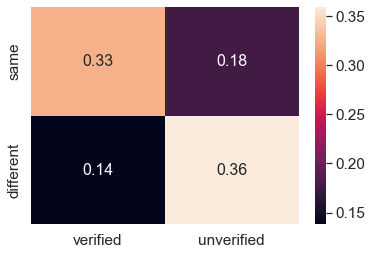

In [33]:
TP=len([x for x in ps if x]) / (len(results) + len(results_neg))
FN=len([x for x in ps if not x]) / (len(results) + len(results_neg))
FP=len([x for x in ns if x]) / (len(results) + len(results_neg))
TN=len([x for x in ns if not x]) / (len(results) + len(results_neg))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[TP,FN],
         [FP,TN]]

df_cm = pd.DataFrame(array, ['same', 'different'], ['verified', 'unverified'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [34]:
TP

0.3259668508287293

In [35]:
FN

0.17679558011049723

In [36]:
FP

0.13812154696132597

In [37]:
len(results) + len(results_neg)

181

In [38]:
[(0.59+x/1000,clf.predict(np.array(0.59+x/1000).reshape(-1, 1))) for x in range(10)]

[(0.59, array([0])),
 (0.591, array([0])),
 (0.592, array([0])),
 (0.593, array([0])),
 (0.594, array([0])),
 (0.595, array([0])),
 (0.596, array([0])),
 (0.597, array([0])),
 (0.598, array([0])),
 (0.599, array([0]))]

In [39]:
import seaborn as sns
total_results = pd.DataFrame(data=[(x[2],"positive") for x in results]+[(x[2],"negative") for x in results_neg], columns=["distance", "type"])

<AxesSubplot:xlabel='distance', ylabel='Percent'>

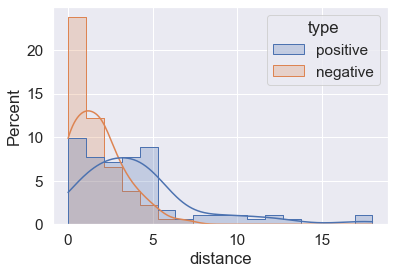

In [40]:
sns.histplot(total_results, x='distance', hue='type', element='step', kde=True, stat='percent')